# Import requried libraries

In [ ]:
!pip install transformers torch accelerate tensorflow-hub bert-tensorflow tensorflow tqdm

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, MarianMTModel, MarianTokenizer, BertConfig
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from datetime import datetime
import re
import nltk
from nltk.corpus import wordnet
import random
from tqdm import tqdm
import concurrent.futures
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import json
import numpy as np
from google.colab import drive
drive.mount("/content/drive")


# Load and clean datasets

In [ ]:
nltk.download('punkt')
dataset_path = "/content/drive/My Drive/Diss_Dataset/dataset500_cleaned.csv"
data = pd.read_csv(dataset_path)

#Extract user IDs, posts and labels
data["userid"] = data.iloc[:, 0]
data["posts"] = data.iloc[:, 1]
data["label"] = data.iloc[:, 2]

#Remove brackets and split posts
data['posts'] = data['posts'].str.strip('[]').str.split("', '")
data['posts'] = data['posts'].apply(lambda x: [post.strip("' ") for post in x])

#Clean individual posts
def clean_post(post):
    url_pattern = re.compile(r'(https?://[^\s]+/[^\s]*|www\.[^\s]+/[^\s]*|\b[a-zA-Z0-9.-]+\.[a-zA-Z]{2,6}/[^\s]*)')
    post = url_pattern.sub('', post)
    post = re.sub(r'\*+', '', post)
    post = re.sub(r'\s+', ' ', post)
    post = re.sub(r'&gt;', '', post)
    post = re.sub(r'[^\x00-\x7F]+', '', post)
    post = re.sub(r'"[^"]*"', '', post)
    post = re.sub(r'\([^)]*\)', '', post)
    post = re.sub(r'[()]', '', post)
    post = re.sub(r'\[[^\]]*\]', '', post)
    post = re.sub(r'[\[\]]', '', post)
    return post.strip().lower()

data["clean_posts"] = data["posts"].apply(lambda posts: [clean_post(post) for post in posts])

#Split posts into sentences
def split_into_sentences(posts, min_length=30, max_length=300):
    sentences = []
    for post in posts:
        split_sentences = re.split(r'(?<=[.!?:])\s*', post)
        filtered_sentences = [sentence for sentence in split_sentences if min_length <= len(sentence) <= max_length]
        sentences.extend(filtered_sentences)
    return sentences

data["sentences"] = data["clean_posts"].apply(split_into_sentences)

print(data.head())

def print_sentences_for_user(data, user_id):
    user_sentences = data[data["userid"] == user_id]["sentences"].tolist()
    print(f"User ID: {user_id}")
    print("Sentences:")
    for sentence in user_sentences[0]:
        print(sentence)
print_sentences_for_user(data, 'user-0')

In [ ]:
dataset_path = "/content/drive/My Drive/Diss_Dataset/dataset2178_cleaned.json"
with open(dataset_path, 'r') as f:
    reddit_data = json.load(f)

reddit_df = pd.DataFrame(list(reddit_data.items()), columns=['userid', 'posts'])

#Clean and split posts
reddit_df['clean_posts'] = reddit_df['posts'].apply(lambda posts: [clean_post(post) for post in posts])

#Split the posts into sentences
reddit_df['sentences'] = reddit_df['clean_posts'].apply(split_into_sentences)

print(reddit_df.head())

def print_sentences_for_user(data, user_id):
    user_sentences = data[data["userid"] == user_id]["sentences"].tolist()
    print(f"User ID: {user_id}")
    print("Sentences:")
    for sentence in user_sentences[0]:
        print(sentence)

print_sentences_for_user(reddit_df, 'user-1118')

In [ ]:
#Import random sentences and clean them
random_sentences_path = "/content/drive/My Drive/Diss_Dataset/random_sentences.csv"
random_sentences_df = pd.read_csv(random_sentences_path)
random_sentences = random_sentences_df["sentence"].tolist()

random_cleaned_sentences = []
for sentence in random_sentences:
    sentence = re.sub(r'\*+', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub(r'&gt;', '', sentence)
    sentence = re.sub(r'[^\x00-\x7F]+', '', sentence)
    sentence = re.sub(r'"[^"]*"', '', sentence)
    sentence = re.sub(r'\*+', '', sentence)
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub(r'[()]', '', sentence)
    sentence = re.sub(r'\[[^\]]*\]', '', sentence)
    sentence = re.sub(r'[\[\]]', '', sentence)
    sentence = sentence.strip().lower()
    if 50 <= len(sentence) <= 300:
        random_cleaned_sentences.append(sentence)

# Filter to sentences including specific phrases

In [ ]:
#Import phrases
phrases_path = "/content/drive/My Drive/Diss_Dataset/phrases2.csv"
with open(phrases_path, 'r', encoding='ISO-8859-1') as file:
    phrases = file.read().split(',')

phrase_sentences = []
non_phrase_sentences = []
def find_phrases(sentences, phrases):
    phrase_sentences = []
    non_phrase_sentences = []
    for sentence in sentences:
        if any(phrase in sentence for phrase in phrases):
            phrase_sentences.append(sentence)
        else:
            non_phrase_sentences.append(sentence)
    return phrase_sentences, non_phrase_sentences

data["phrase_sentences"], data["non_phrase_sentences"] = zip(*data["sentences"].apply(lambda x: find_phrases(x, phrases)))

non_phrase_sentences = [sentence for sublist in data["non_phrase_sentences"] for sentence in sublist]
phrase_sentences = [sentence for sentence_list, label in zip(data["phrase_sentences"], data["label"]) for sentence in sentence_list]
print(len(non_phrase_sentences))
print(len(phrase_sentences))
print(len(random_cleaned_sentences))
downsampled_random_sentences = random.sample(random_cleaned_sentences, 8000)
print(len(downsampled_random_sentences))
print(downsampled_random_sentences[:10])
print(phrase_sentences[:10])
combined_sentences = phrase_sentences + downsampled_random_sentences
combined_labels = [1] * len(phrase_sentences) + [0] * len(downsampled_random_sentences)

#Create new dataframe for random and phrase sentences
combined_df = pd.DataFrame({
    'sentence': combined_sentences,
    'label': combined_labels
})
#Complete train/test split
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['label'])



28789
10468
61568
8000
['famed comicbook artist jack kirby was even contracted to produce artwork for set design.', 'various people are seated in chairs before some sort of indoor event.', 'the film is set in quebec city in two distinct time periods.', 'two members of the latter group were doctor thomas s smith and florence nightingale.', 'the accident damaged the car beyond repair and it was a writeoff.', 'the little boy looks like he is doing a school project while his dad watches him.', 'artists included edward ardizzone roland emmett l s lowry lawrence scarfe and richard chopping.', 'as dawn broke the city of london brigade occupied cheriton wood.', 'a sinewy hand dripping with water was clutching the rail.', 'rusk repeatedly offered his resignation but it was never accepted.']
['youd pain her beyond comprehension.', 'it can definitely feel hopeless, as you seem to be very aware of.', 'over time, one day you will arrive at a level where you again feel at peace and can start feeling

# Train model and classify whether likely to be in Subreddit

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#Load BERT base uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

class SuicideRiskDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        sentence = row["sentence"]
        label = row["label"]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'sentence_text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SuicideRiskDataset(train_df, tokenizer, max_len=128)
valid_dataset = SuicideRiskDataset(test_df, tokenizer, max_len=128)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    gradient_accumulation_steps=4,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

In [ ]:
def predict_topic(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    return predictions.cpu().numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Predict risk levels for all sentences
all_predictions = []
for index, row in data.iterrows():
    user_id = row["userid"]
    sentences = row["sentences"]
    if sentences:
        predicted_labels = predict_topic(sentences)
        for sentence, label in zip(sentences, predicted_labels):
            all_predictions.append((user_id, sentence, label))

#Convert predictions to a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=["userid", "sentence", "predicted_label"])
csv_file_path = "/content/drive/My Drive/Diss_Dataset/predictions2.csv"
predictions_df.to_csv(csv_file_path, index=False)

filtered_predictions = predictions_df[predictions_df["predicted_label"] == 1]
merged_df = pd.merge(filtered_predictions, data[["userid", "label"]], on="userid", how="left")
result_df = merged_df[["userid", "sentence", "label"]]
result_df['sentence'] = result_df['sentence'].apply(lambda x: [x] if isinstance(x, str) else x)
print(result_df.head())

In [ ]:
all_predictions2 = []
for index, row in reddit_df.iterrows():
    user_id = row["userid"]
    sentences = row["sentences"]
    print(sentences)
    for sentence in sentences:
        label = predict_topic(sentence)
        all_predictions2.append((user_id, sentence, label))

predictions_df2 = pd.DataFrame(all_predictions2, columns=["userid", "sentence", "predicted_label"])
csv_file_path2 = "/content/drive/My Drive/Diss_Dataset/reddit_predictions.csv"
predictions_df2.to_csv(csv_file_path2, index=False)

filtered_predictions2 = predictions_df2[predictions_df2["predicted_label"] == 1]
merged_df2 = pd.merge(filtered_predictions2, reddit_df[["userid", "label"]], on="userid", how="left")
result_df2 = merged_df2[["userid", "sentence", "label"]]
result_df2['sentence'] = result_df2['sentence'].apply(lambda x: [x] if isinstance(x, str) else x)
print(result_df2.head())

# Filter down to "Supportive/Attempt" statements

In [ ]:
del model
del tokenizer
torch.cuda.empty_cache()
supportive_sentences = []
non_supportive_sentences = []
for index, row in result_df.iterrows():
        if row['label'] == 'Supportive':
            supportive_sentences.extend(row['sentence'])
        if row['label'] == 'Attempt':
            non_supportive_sentences.extend(row['sentence'])
print(f"Number of supportive sentences: {len(supportive_sentences)}")
print(supportive_sentences[0])
print(f"Number of non supportive sentences: {len(non_supportive_sentences)}")
print(non_supportive_sentences[0])
combined_df = pd.DataFrame({
    'sentence': supportive_sentences + non_supportive_sentences,
    'label': [1] * len(supportive_sentences) + [0] * len(non_supportive_sentences)
})
combined_dir = "/content/drive/My Drive/Diss_Dataset/Supportiveness_raw.csv"
combined_df.to_csv(combined_dir, index=False)

# Re-read Supportive/Attempt sentences

In [ ]:
combined_sentences_dir = "/content/drive/My Drive/Diss_Dataset/Supportiveness.csv"
combined_df = pd.read_csv(combined_sentences_dir)
print(combined_df.head())

combined_sentences = combined_df["sentence"].tolist()
print(combined_sentences[:10])

train_df, temp_df = train_test_split(combined_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Number of combined sentences: {len(combined_df)}")
print(train_df.head())
print(val_df.head())
print(test_df.head())

# Data Augmentation

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet

MIN_CHAR_LENGTH = 30
MAX_CHAR_LENGTH = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Backtranslation models
en_fr_model_name = 'Helsinki-NLP/opus-mt-en-fr'
en_fr_tokenizer = MarianTokenizer.from_pretrained(en_fr_model_name)
en_fr_model = MarianMTModel.from_pretrained(en_fr_model_name).to(device)

fr_en_model_name = 'Helsinki-NLP/opus-mt-fr-en'
fr_en_tokenizer = MarianTokenizer.from_pretrained(fr_en_model_name)
fr_en_model = MarianMTModel.from_pretrained(fr_en_model_name).to(device)

BATCH_SIZE = 128
#Backtranslation Function
def backtranslate(sentences, source_lang="en", target_lang="fr"):
    backtranslated_sentences = []

    for i in range(0, len(sentences), BATCH_SIZE):
        batch = sentences[i:i+BATCH_SIZE]

        encoded = en_fr_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        translated = en_fr_model.generate(**encoded)
        translated_sentences = [en_fr_tokenizer.decode(t, skip_special_tokens=True) for t in translated]

        back_encoded = fr_en_tokenizer(translated_sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        back_translated = fr_en_model.generate(**back_encoded)
        back_translated_sentences = [fr_en_tokenizer.decode(t, skip_special_tokens=True) for t in back_translated]

        for orig, back_translated_sentence in zip(batch, back_translated_sentences):
            if MIN_CHAR_LENGTH <= len(back_translated_sentence) <= MAX_CHAR_LENGTH:
                backtranslated_sentences.append(back_translated_sentence)
            else:
                backtranslated_sentences.append(orig)

    return backtranslated_sentences

#Synonym Replacement function
def synonym_replacement(sentences, n=1):
    augmented_sentences = []
    for sentence in sentences:
        words = sentence.split()
        new_sentence = words.copy()
        for _ in range(n):
            word_to_replace = random.choice(words)
            synonyms = wordnet.synsets(word_to_replace)
            if synonyms:
                lemmas = [lemma.name() for lemma in synonyms[0].lemmas() if lemma.name() != word_to_replace]
                if lemmas:
                    synonym = random.choice(lemmas)
                    new_sentence = [synonym if word == word_to_replace else word for word in new_sentence]
        augmented_sentence = ' '.join(new_sentence)
        if MIN_CHAR_LENGTH <= len(augmented_sentence) <= MAX_CHAR_LENGTH:
            augmented_sentences.append(augmented_sentence)
        else:
            augmented_sentences.append(sentence)
    return augmented_sentences

def eda(sentences):
    techniques = [synonym_replacement, backtranslate]
    augmentation = random.choice(techniques)
    return augmentation(sentences)

In [ ]:
augmentation_fraction = 0.2
sampled_train_df = train_df.sample(frac=augmentation_fraction, random_state=42)

sentences = sampled_train_df['sentence'].tolist()
labels = sampled_train_df['label'].tolist()

augmented_sentences = []
original_sentences = []
augmented_labels = []

for i in tqdm(range(0, len(sentences), BATCH_SIZE)):
    batch_sentences = sentences[i:i + BATCH_SIZE]
    batch_labels = labels[i:i + BATCH_SIZE]
    augmented_batch = eda(batch_sentences)

    original_sentences.extend(batch_sentences)
    augmented_sentences.extend(augmented_batch)
    augmented_labels.extend(batch_labels)

augmented_train_df = pd.DataFrame({
    'sentence': augmented_sentences,
    'label': augmented_labels
})

augmented_train_df = pd.concat([train_df, augmented_train_df], ignore_index=True)

print(f"Original training set size: {len(train_df)}")
print(f"Augmented training set size: {len(augmented_train_df)}")

In [ ]:
print(len(augmented_train_df))
print(len(val_df))
print(len(test_df))

df_majority = augmented_train_df[augmented_train_df['label'] == 1]
df_minority = augmented_train_df[augmented_train_df['label'] == 0]


df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)


augmented_train_df_downsampled = pd.concat([df_minority, df_majority_downsampled])

augmented_train_df_downsampled = augmented_train_df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(augmented_train_df_downsampled['label'].value_counts())

7850
1402
1403
label
0    1237
1    1237
Name: count, dtype: int64


# Supportiveness model training

In [ ]:
del fr_en_model
del en_fr_model
del fr_en_tokenizer
del en_fr_tokenizer

In [ ]:
from sklearn.metrics import f1_score
torch.cuda.empty_cache()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_data(sentences, max_length=128):
    encodings = tokenizer(
        sentences.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    return encodings

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(f"Learning rate at the end of epoch {epoch + 1}: {lr.numpy()}")

class WarmupExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, decay_steps, decay_rate=0.7):
        super(WarmupExponentialDecay, self).__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.decay_steps = tf.cast(decay_steps, tf.float32)
        self.decay_rate = tf.cast(decay_rate, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        decay_lr = self.initial_learning_rate * tf.math.pow(self.decay_rate, (step - self.warmup_steps) / self.decay_steps)
        return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate.numpy(),
            "warmup_steps": self.warmup_steps.numpy(),
            "decay_steps": self.decay_steps.numpy(),
            "decay_rate": self.decay_rate.numpy(),
        }

train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)
print(train_df.head())
print(val_df.head())

train_encodings = tokenize_data(augmented_train_df_downsampled['sentence'])
val_encodings = tokenize_data(val_df['sentence'])
test_encodings = tokenize_data(test_df['sentence'])

train_labels = tf.convert_to_tensor(augmented_train_df_downsampled['label'].values)
val_labels = tf.convert_to_tensor(val_df['label'].values)
test_labels = tf.convert_to_tensor(test_df['label'].values)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

config = BertConfig.from_pretrained('bert-base-uncased',
                                    hidden_dropout_prob=0.3,
                                    num_labels=2)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
l2_lambda = 0.01
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)
initial_lr = 1e-5
warmup_steps = 100
learning_rate = WarmupExponentialDecay(initial_learning_rate=initial_lr, warmup_steps=warmup_steps, decay_steps=100, decay_rate=0.7)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
class PrintMetrics(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PrintMetrics, self).__init__()
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: loss = {logs['loss']:.4f}, accuracy = {logs['accuracy']:.4f}, "
              f"val_loss = {logs['val_loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}")
        val_pred = self.model.predict(val_dataset.batch(16)).logits
        val_pred_labels = tf.argmax(val_pred, axis=1)
        val_f1 = f1_score(val_labels, val_pred_labels, average='weighted')
        self.f1_scores.append(val_f1)
        print(f"F1 Score for validation set: {val_f1:.4f}")

print_metrics_callback = PrintMetrics()
callbacks = [
    print_metrics_callback,
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/Diss_Dataset/best_supportive_model',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    PrintLearningRate()
]

history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    validation_data=val_dataset.batch(16),
    epochs=10,
    callbacks=callbacks
)

model.save_pretrained('/content/drive/My Drive/Diss_Dataset/best_supportive_model')
tokenizer.save_pretrained('/content/drive/My Drive/Diss_Dataset/best_supportive_model')

val_loss, val_accuracy = model.evaluate(val_dataset.batch(16))
print(f"Validation accuracy: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(test_dataset.batch(16))
print(f"Test accuracy: {test_accuracy}")

# Visualise Results

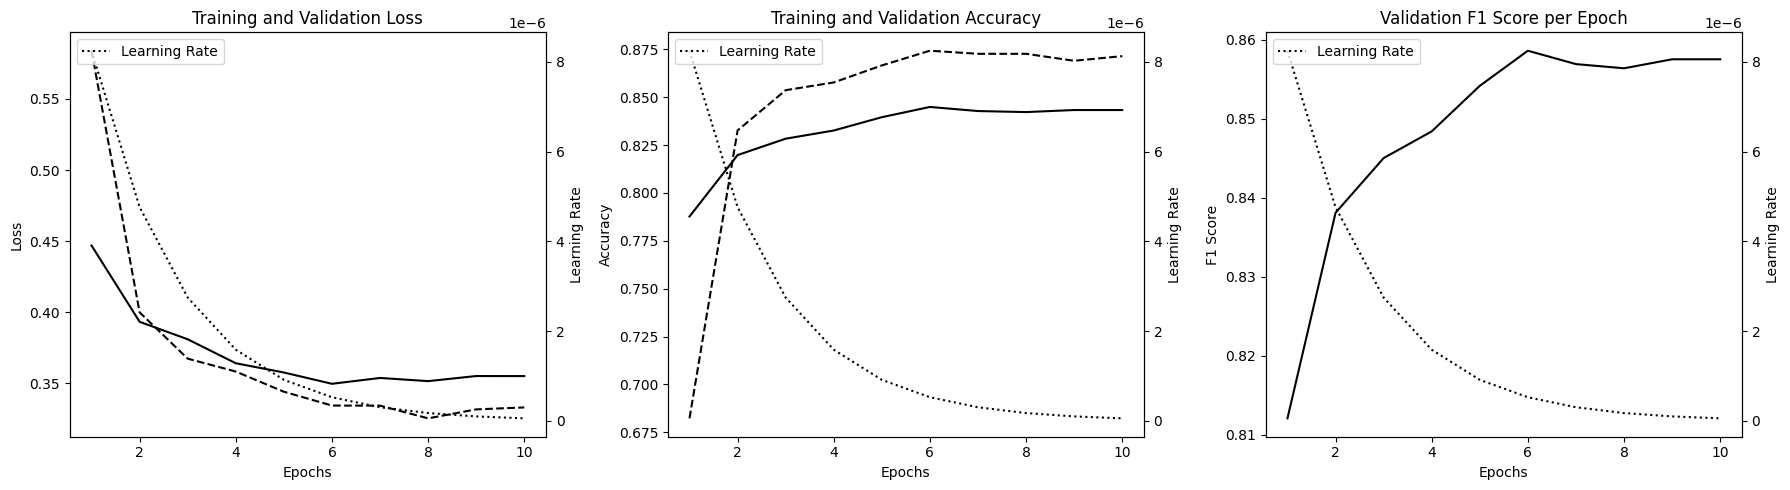

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, f1_scores, learning_rate_schedule, steps_per_epoch):
    epochs = range(1, len(history.history['loss']) + 1)
    learning_rates = [learning_rate_schedule(step * steps_per_epoch).numpy() for step in epochs]
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], 'k--', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'k-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    ax2 = plt.gca().twinx()
    ax2.plot(epochs, learning_rates, 'k:', label='Learning Rate')
    ax2.set_ylabel('Learning Rate', color='black')
    plt.legend(loc='upper left')

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['accuracy'], 'k--', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'k-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    ax2 = plt.gca().twinx()
    ax2.plot(epochs, learning_rates, 'k:', label='Learning Rate')
    ax2.set_ylabel('Learning Rate', color='black')
    plt.legend(loc='upper left')

    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_scores, 'k-', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score per Epoch')

    ax2 = plt.gca().twinx()
    ax2.plot(epochs, learning_rates, 'k:', label='Learning Rate')
    ax2.set_ylabel('Learning Rate', color='black')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

steps_per_epoch = len(train_dataset) // 16

plot_metrics(history, print_metrics_callback.f1_scores, learning_rate, steps_per_epoch)


88/88 [==============================] - 2s 27ms/step


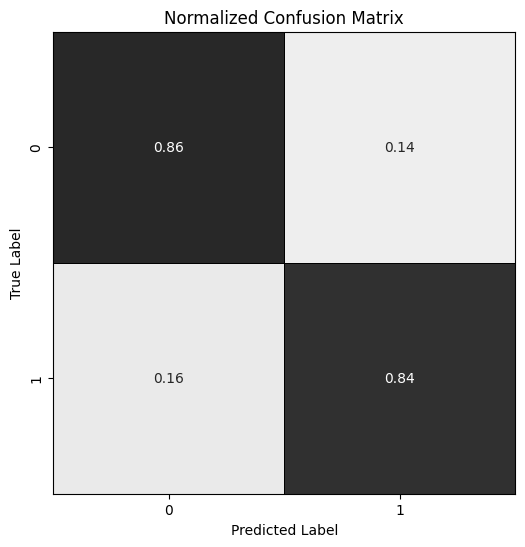

In [ ]:
import seaborn as sns

y_true = test_labels.numpy()
y_pred = tf.argmax(model.predict(test_dataset.batch(16)).logits, axis=1).numpy()

cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greys', cbar=False, linewidths=.5, square=True,
            linecolor='black', vmin=0, vmax=1, clip_on=False, edgecolor='black', linestyle='-', lw=0.5)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.show()

# Classify all sentences as supportive/non-supportive and save to CSV file

In [ ]:
import numpy as np
from tqdm import tqdm

def predict_supportiveness_batch(sentences):
    inputs = tokenizer(sentences, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = model(inputs, training=False)
    predictions = np.argmax(outputs.logits, axis=1)
    return predictions

batch_size = 1024

all_supportiveness_predictions = []

all_sentences = [sentence for sentences in result_df['sentence'] for sentence in sentences]

for i in tqdm(range(0, len(all_sentences), batch_size), desc="Predicting Supportiveness"):
    batch_sentences = all_sentences[i:i + batch_size]
    predicted_labels = predict_supportiveness_batch(batch_sentences)
    all_supportiveness_predictions.extend(predicted_labels)

result_df["predicted_supportiveness_label"] = all_supportiveness_predictions

print(f"Total predictions made: {len(all_supportiveness_predictions)}")


In [ ]:
all_supportiveness_predictions2 = []

all_sentences2 = [sentence for sentences in result_df2['sentence'] for sentence in sentences]

for i in tqdm(range(0, len(all_sentences2), batch_size), desc="Predicting Supportiveness"):
    batch_sentences = all_sentences2[i:i + batch_size]
    predicted_labels = predict_supportiveness_batch(batch_sentences)
    all_supportiveness_predictions2.extend(predicted_labels)

result_df2["predicted_supportiveness_label"] = all_supportiveness_predictions2

print(f"Total predictions made: {len(all_supportiveness_predictions2)}")

In [ ]:
print(result_df.head())
print(result_df2.head())

In [ ]:
output_csv_path = "/content/drive/My Drive/Diss_Dataset/predicted_supportiveness.csv"

result_df.to_csv(output_csv_path, index=False)

print(f"DataFrame saved to {output_csv_path}")

output_csv_path2 = "/content/drive/My Drive/Diss_Dataset/predicted_supportiveness_all.csv"

result_df2.to_csv(output_csv_path2, index=False)